### Decision Tree (DecisionTree.ipynb)
Train a Decision Tree classifier, selecting a rule for when it is time to stop branching to
avoid overfitting.

Goal: See how a ChoiceMaker performs when applied to a novel area. Having the lowest error 
compared to naive methods would be great.

Comparison: We compare against a naive way of making a decision tree algorithm
private, as well as another method described in a sketchy paper. I implemented
everything.

Current Results: The Choicemaker seems to be competitive with the two other methods
sometimes. We definitely need more data supporting this claim for a final submission.

Improvement 1: figure out a way to make epsilon equal to 1.0 always.
Improvement 2: simplify the error computations.


In [1]:
import DPrivacy as dp
from ChoiceMaker import DTChoice
from sklearn import model_selection, feature_selection
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
%matplotlib inline
import pickle
import collections

In [2]:
from decision_tree import CoefCM, Leaf, Split, DB, DBMetas, PDTree

In [3]:
tree_algs = {'leaf': Leaf(), 'split': Split()}
fried_cm = CoefCM([1, 0, 1, 0, -1, 0, -1], np.log(1.414))

### DATASETS

In [4]:
adult = pickle.load(open('decision_tree_data/adult.pkl', 'rb'))

nurs = pd.read_csv('../datasets/nursery.data', header=None)
nurs = nurs.apply(lambda x: x.astype('category'))

skin = pd.read_csv('data/Skin.csv', sep='\t', header=None)
skin = skin.apply(lambda x: x.astype('category'))

default = pickle.load(open('decision_tree_data/default.pkl', 'rb'))

loan = pd.read_csv('../datasets/student-loan.csv')
loan = loan.apply(lambda x: x.astype('category'))

lending = pickle.load(open('decision_tree_data/lending.pkl', 'rb'))

In [5]:
class null_cm:
    def __init__(self):
        self.leaf = Leaf()
        self.split = Split()
    def choose(self, db):
        if db.depth < db.max_depth:
            return self.split.run(db)
        else:
            return self.leaf.run(db)

### Experiments

In [6]:
def get_train_dbs(seed_db, eps, prng):
    regs = []
    X = []
    D = []
    for l in range(1, 4): #Used to be 6
        for x in range(2**(l+3)):
            cols = prng.permutation(seed_db.columns[:-1])
            db_groups = seed_db.groupby(list(cols[:l])).groups
            idxs = db_groups[list(db_groups)[prng.randint(len(db_groups))]]
            L = idxs.size
            L = min(L, 5000)
            L = prng.randint(0.7*L, L)
            idxs = prng.choice(idxs, L)
            data = DB(seed_db.loc[idxs, cols[l:]], seed_db.loc[idxs, seed_db.columns[-1]], None, None, epsilon=eps, depth=l)
            regs.append({name: alg.error(data) for name, alg in tree_algs.items()})
            X.append(DBMetas()(data))
            D.append(data)
    #Large DBs    
    for x in range(16):
        cols = seed_db.columns[:-1]
        L = len(seed_db)
        L = min(L, 5000)
        L = prng.randint(0.7*L, L)
        new_db = seed_db.sample(L, random_state=prng)
        data = DB(new_db.loc[:, cols], new_db.loc[:, seed_db.columns[-1]], None, None, epsilon=eps, depth=0)
        regs.append({name: alg.error(data) for name, alg in tree_algs.items()})
        X.append(DBMetas()(data))
        D.append(data)
    return (regs, X, D)

In [7]:
def get_test_dbs(seed_db, eps, prng):
    cols = seed_db.columns[:-1]
    y_col = seed_db.columns[-1]
    L = len(seed_db)
    L = min(L, int(5000/0.7))
    L = prng.randint(0.7*L, L)
    new_db = seed_db.sample(L, random_state=prng).reset_index(drop=True)
    split = int(0.7*L)
    md = min(len(cols), 4)
    d = DB(new_db.loc[:split, cols], new_db.loc[:split, y_col], \
           new_db.loc[split:, cols], new_db.loc[split:, y_col], epsilon=eps, max_depth=md)
    return d

In [ ]:
prng=np.random.RandomState(12345)
eps_vals = np.array([0.05, 0.1, 0.25, 0.5, 0.8])
def get_test(db, prng):
    dbs = []
    for i in range(0, 3):
        for e in eps_vals:
            dbs.append(get_train_dbs(db, e, prng))
    return dbs
data_train = [get_test(db, prng) for db in [nurs, default, loan, adult, lending]]

In [48]:
def get_cm(info):
    regrets, X, datas = zip(*info)
    regrets = pd.concat([pd.DataFrame(r) for r in regrets], ignore_index=True)
    X = pd.concat([pd.DataFrame(r) for r in X], ignore_index=True)
    return DTChoice(X, DBMetas(), tree_algs, regrets=regrets)

out = [get_cm(o) for o in data_train]

In [58]:
#pickle.dump([cm.X for cm in out], open('decision_tree_metadata/data2.pkl', 'wb'))
#pickle.dump([cm.regrets for cm in out], open('decision_tree_metadata/regrets2.pkl', 'wb'))

In [9]:
#We have already run the above code so you don't have to!
mfs = pickle.load(open('decision_tree_metadata/data2.pkl', 'rb'))
regs = pickle.load(open('decision_tree_metadata/regrets2.pkl', 'rb'))
tdbs = pickle.load(open('decision_tree_metadata/training_dbs.pkl', 'rb'))

In [10]:
cms = [ DTChoice(mfs[i], DBMetas(), tree_algs, regrets=regs[i]) for i in range(len(mfs))]

In [11]:
def combine_cms(cms, C=0, msl=1):
    Xs = pd.concat([cm.X for cm in cms], ignore_index=True)
    regs = pd.concat([cm.regrets for cm in cms], ignore_index=True)
    dt = DTChoice(Xs, DBMetas(), tree_algs, regrets=regs, C=0)
    dt.model = DecisionTreeClassifier(min_samples_leaf=msl, max_depth=3)
    dt.retrain_model()
    return dt

In [27]:
def get_results(dbs, cm_list):
    budgets = [x.epsilon for x in dbs]
    ans = []
    for cm in cm_list:
        dt = PDTree()
        L = []
        for t in dbs:
            L.append( dt.fit_and_predict(t, cm) )
            print(dt.leaf.numruns)
        for i in range(len(dbs)):
            dbs[i].epsilon = budgets[i]
        M = np.array([(L[i] == dbs[i].y_test).sum() / len(dbs[i].y_test) for i in range(len(dbs))])
        ans.append(M)
    return ans

In [13]:
prng = np.random.RandomState(12345)

### Experiment 0

In [95]:
comp_cm0 = cms[0]
comp_cm0 = combine_cms(cms[1:])
big_cm0.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
big_cm0.retrain_model()
comp_cm0.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
comp_cm0.retrain_model()

In [96]:
nursdata = [get_test_dbs(nurs, 0.25, prng) for x in range(0, 5)]

In [97]:
res0 = get_results(nursdata, [null_cm(), big_cm0, comp_cm0, fried_cm])

132
238
340
438
561
0
4
14
14
14
0
0
0
0
0
0
0
0
0
0


In [98]:
np.array(res0).mean(axis=1) #Overfitting

array([ 0.41259083,  0.53268695,  0.54068402,  0.50523581])

In [134]:
epsilon = 0.25

### Experiment 1

In [105]:
comp_cm1 = cms[1]
big_cm1 = combine_cms(cms[:1] + cms[2:])
big_cm1.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
big_cm1.retrain_model()
comp_cm1.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
comp_cm1.retrain_model()

In [106]:
defaultsdata = [get_test_dbs(default, epsilon, prng) for i in range(0, 5)]

In [107]:
res1 = get_results(defaultsdata, [null_cm(), big_cm1, comp_cm1, fried_cm])

252
604
904
1156
1478
0
0
4
10
12
0
0
0
0
0
0
0
0
0
0


In [108]:
(np.array(res1)).mean(axis=1)

array([ 0.67104495,  0.78070992,  0.77980918,  0.7569951 ])

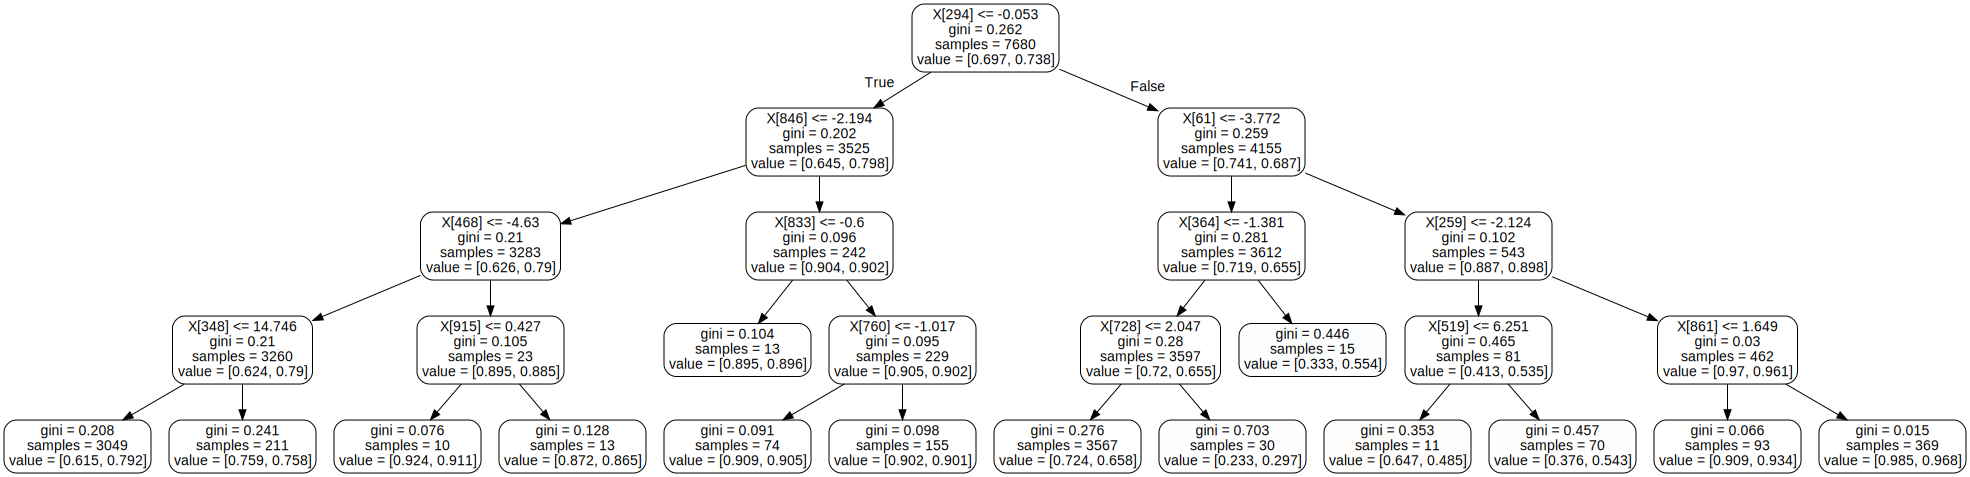

In [109]:
dot_data = export_graphviz(big_cm1.model, out_file = None, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

### Experiment 2

In [110]:
big_cm2 = combine_cms(cms[:2] + cms[3:])
comp_cm2 = cms[2]
big_cm2.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=1)
big_cm2.retrain_model()
comp_cm2.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=1)
comp_cm2.retrain_model()

In [111]:
loandata = [get_test_dbs(loan, epsilon, prng) for i in range(5)]

In [112]:
res2 = get_results(loandata, [null_cm(), big_cm2, comp_cm2, fried_cm])

109
259
325
439
497
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [113]:
np.array(res2).mean(axis=1)

array([ 0.61858333,  0.89671604,  0.89671604,  0.89671604])

### Experiment 3

In [114]:
big_cm3 = combine_cms(cms[:3] + cms[4:])
comp_cm3 = cms[3]
big_cm3.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=1)
big_cm3.retrain_model()
comp_cm3.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=1)
comp_cm3.retrain_model()

In [115]:
adultdata = [get_test_dbs(adult, epsilon, prng) for i in range(5)]

In [116]:
res3 = get_results(adultdata, [null_cm(), big_cm3, comp_cm3, fried_cm])

449
769
1153
1435
1633
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [117]:
np.array(res3).mean(axis=1)

array([ 0.67137373,  0.76513876,  0.76807864,  0.7423111 ])

### Experiment 4

In [118]:
big_cm4 = combine_cms(cms[:4] + cms[5:])
comp_cm4 = cms[4]
big_cm4.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
big_cm4.retrain_model()
comp_cm4.model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
comp_cm4.retrain_model()

In [119]:
lendingdata = [get_test_dbs(lending, epsilon, prng) for x in range(5)]

In [127]:
res4 = get_results(lendingdata, [null_cm(), big_cm4, comp_cm3, fried_cm])

189
518
792
1199
1527
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [128]:
np.array(res4).mean(axis=1)

array([ 0.5716228 ,  0.85011227,  0.8325532 ,  0.83701077])

In [136]:
#E = np.array([res0,res1,res2,res3,res4])
#pickle.dump(E, open('decision_tree_data/perf0.25', 'wb'))

In [141]:
E = pickle.load(open('decision_tree_data/perf0.25', 'rb'))

In [153]:
#E[dataset][algorithm][trial]
stds = E.std(axis=2).mean(axis=0)

In [143]:
errors = 1.0-E.mean(axis=2).mean(axis=0)

In [144]:
errors

array([ 0.41095687,  0.23492721,  0.23643179,  0.25234624])

In [146]:
import matplotlib.patches as mpatches

In [150]:
colors = ['red', 'blue', 'green', 'orange']

In [151]:
patches = [mpatches.Patch(color=c) for c in colors]

<Container object of 4 artists>

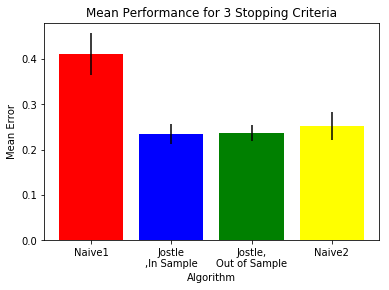

In [159]:
fig, axis = plt.subplots()
axis.set_xticks([0,1,2,3])
axis.set_xticklabels(['Naive1','Jostle\n,In Sample','Jostle,\nOut of Sample','Naive2'])
axis.set_xlabel('Algorithm')
axis.set_ylabel('Mean Error')
#axis.legend(handles=patches, labels=['Alg1', 'Alg2', 'Jostle'])
axis.set_title('Mean Performance for 3 Stopping Criteria')
axis.bar(range(4), errors, color=colors, yerr=stds)

In [ ]:
#Once we test multiple epsilons, we can use this code

In [294]:
x_pos = np.array([4*x + y for x in [0,1,2] for y in [0,1,2]])

In [295]:
colors = ['red', 'blue', 'green']*3

In [296]:
patches = [mpatches.Patch(color=c) for c in ['red', 'blue', 'green']]

<Container object of 9 artists>

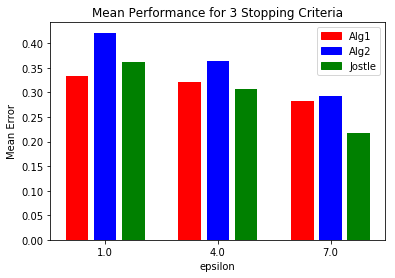

In [297]:
fig, axis = plt.subplots()
axis.set_xticks([1,5,9])
axis.set_xticklabels(['1.0', '4.0', '7.0'])
axis.set_xlabel('epsilon')
axis.set_ylabel('Mean Error')
axis.legend(handles=patches, labels=['Alg1', 'Alg2', 'Jostle'])
axis.set_title('Mean Performance for 3 Stopping Criteria')
axis.bar(x_pos, juxtaposed_alg_perfs, color=colors)

In [ ]:
fig, axis = plt.subplots()
for a in 